In [1]:
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import numpy as np
import sys
%matplotlib inline

In [2]:
def time_in_seconds(val):
    if "-" in val:
        fields = val.split("-")
        sec=0.0
        for i in fields:
            if "s" in i: sec += float(i.strip("s"))
            if "m" in i: sec += 60 * float(i.strip("m"))
            if "h" in i: sec += 3600 * float(i.strip("h"))
        return sec
    else:
        return float(val.strip("s"))

In [3]:
def parse_report(file_name):
    buffer = []
    resources_dict = {
        "MPI Cores": "mpi", "Threads per core": "thrs", "Threads total": "thr_tot", 
        "Nodes Computing": "nodes", "Nodes IO": "nodes_io", "MPI tasks / GPU": "mpi/gpu",
    }
    resources = {}
    timing = {}
    log = False
    with open(file_name, 'r') as report:
        for line in report:
            if line == "\n": log = False
            if log: 
                buffer.append(line.strip())
            else:
                for key, val in resources_dict.items():
                    if key in line: resources[val] = int(line.strip().split(":")[1])
                if "Time-Profile" in line:
                    timing["Time-Profile"] = time_in_seconds(line.strip().split(":")[1])

            if "Clock:" in line: log = True

    for line in buffer:
        fields = line.split(":")
        timing[fields[0].strip()] = time_in_seconds(fields[1].strip().split()[0])
    return resources, timing

In [4]:
def build_dataframe(x_axis='mpi', factor=1, rename_cols={}):
    r_files = glob("r-*")

    data = {}
    for report in r_files:
        resources, timing = parse_report(report)
        for key, val in resources.items():
            if key in data:
                data[key].append(val)
            else:
                data[key] = [val,]
        for key, val in timing.items():
            if key in data:
                data[key].append(val)
            else:
                data[key] = [val,]
    
    scaling = pd.DataFrame(data)
    if rename_cols: 
        scaling.rename(columns=rename_cols, inplace=True)
    else:
        scaling.rename(columns={'Xo (procedure)': 'Xo', 'X (procedure)': 'X'}, inplace=True)
    scaling.sort_values(by=[x_axis], inplace=True)
    if 'mpi/gpu' in scaling: scaling['gpu'] = pd.Series(scaling['mpi'] / scaling['mpi/gpu'], dtype=np.int64)
    scaling['ideal'] = scaling[x_axis] / factor
    scaling['speedup'] = scaling[scaling[x_axis]>=factor]['Time-Profile'].max() / scaling['Time-Profile']
    scaling['efficiency'] = scaling.speedup / scaling.ideal * 100
    scaling['Self energy'] = scaling['HF'] + scaling['GW(mpa)'] - scaling['GW(mpa)_init']
    scaling['Other'] = scaling['Time-Profile'] - scaling['Dipoles'] - scaling['Xo'] - scaling['X'] - scaling['Self energy']
    scaling['node_h'] = scaling['nodes'] * scaling['Time-Profile'] / 3600
    return scaling

In [5]:
def build_scaling_plot(scaling, pile, colors, x_axis='mpi', x_label='MPI tasks', bar_width=1,
                       title=None, legend_loc=None, label=None, label_pos=None, efficiency=True, 
                       file_name='scaling.png', y_lim=None):
    if len(pile) != len(colors):
        sys.stderr.write("Error: the number of elements of pile and colors lists have to be the same.")
        return
    fig, ax1 = plt.subplots(figsize=(7, 5))

    bottom = pd.Series(dtype='float64')
    for key, color in zip(pile, colors):
        if bottom.empty:
            ax1.bar(scaling[x_axis], scaling[key], width=bar_width, color=color, label=key)
            bottom = scaling[key].copy()
        else:
            ax1.bar(scaling[x_axis], scaling[key], width=bar_width, color=color, label=key, bottom=bottom)
            bottom += scaling[key]

    ax1.set_xlabel(x_label,fontsize=20)
    ax1.set_ylabel('Time (sec)',fontsize=20)
    ax1.legend()
    if y_lim: ax1.set_ylim(y_lim)
    if legend_loc: ax1.legend(fontsize='18',framealpha=0.0, loc=legend_loc)
    ax1.tick_params(axis = 'both', which = 'major', labelsize = 18)
    if label and label_pos: ax1.text(*label_pos, label, fontsize=20)
    plt.xticks(scaling[x_axis])
    
    if efficiency:
        eff_color='tab:blue'
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_ylim([-10, 110])
        ax2.set_ylabel('Efficiency (%)', color=eff_color,fontsize=20)  # we already handled the x-label with ax1
        ax2.plot(scaling[x_axis], scaling['efficiency'], linewidth=3, color=eff_color)
        ax2.tick_params(axis='y', labelcolor=eff_color, labelsize=18)
        fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    if title: plt.title(title, fontsize=20)
    plt.savefig(file_name, bbox_inches='tight')

In [6]:
def build_cost_plot(scaling, label='yambo', title=None, y_lim=None, file_name='cost.pdf'):
    fig2, ax3 = plt.subplots(figsize=(10, 7))
    ax3.set_xlabel('Time to solution (sec)',fontsize=20)
    ax3.set_ylabel('Cost (node*hour)',fontsize=20)
    ax3.plot(scaling['Time-Profile'], scaling['node_h'], 
             linewidth=3, color=colors[0], marker='.', markersize=15,
             label=label)
    if y_lim: ax3.set_ylim(y_lim)
    ax3.legend()
    ax3.legend(fontsize='18',framealpha=0.0)

    if title: plt.title(title, fontsize=20)
    plt.savefig(file_name)

In [7]:
scaling = build_dataframe(x_axis='mpi', factor=2000)
scaling.to_csv('scaling.csv', sep='\t')
scaling

mpi  thrs  thr_tot  nodes  nodes_io  mpi/gpu  Time-Profile  \
3   2000     8    16000    500         1        1       13320.0   
1   4000     8    32000   1000         1        1        8700.0   
0   8000     8    64000   2000         1        1        5760.0   
2  12000     8    96000   3000         1        1        4380.0   

   GW(mpa)_poles_io  io_ATMPROJ_pwscf  io_KB_abinit  ...  GW(mpa)_init  \
3            0.0001            0.0062        0.0031  ...      172.8418   
1            0.0001            0.0118        0.0210  ...      467.4166   
0            0.0001            0.0338        0.0363  ...      658.0000   
2            0.0001            0.0407        0.0202  ...      478.7951   

    GW(mpa)       Xo    gpu  ideal   speedup  efficiency  Self energy  \
3  370.2331  11760.0   2000    1.0  1.000000  100.000000     197.4424   
1  631.0000   6600.0   4000    2.0  1.531034   76.551724     163.6122   
0  813.0000   3449.0   8000    4.0  2.312500   57.812500     155.0603   
2  645.0000   2485.0  12000    6.0  3.041096   50.684932     166.2180   

       Other       node_h  
3  1091.9089  1850.000000  
1  1480.4603  2416.666667  
0  1711.4842  3200.000000  
2  1422.8722  3650.000000  

[4 rows x 91 columns]

In [8]:
#colors=['#2EA6A6', '#F28F38', '#47AB6C', '#112F41', '#D90718']
colors=['#F28F38', '#2EA6A6', '#D90718', '#47AB6C', '#112F41']
pile = ['Dipoles', 'Xo', 'X', 'Self energy', 'Other']
scaling[['mpi', 'Time-Profile'] + pile + ['efficiency']]

mpi  Time-Profile   Dipoles       Xo         X  Self energy      Other  \
3   2000       13320.0   96.9026  11760.0  173.7461     197.4424  1091.9089   
1   4000        8700.0  277.6414   6600.0  178.2861     163.6122  1480.4603   
0   8000        5760.0  245.9124   3449.0  198.5431     155.0603  1711.4842   
2  12000        4380.0  119.7273   2485.0  186.1825     166.2180  1422.8722   

   efficiency  
3  100.000000  
1   76.551724  
0   57.812500  
2   50.684932

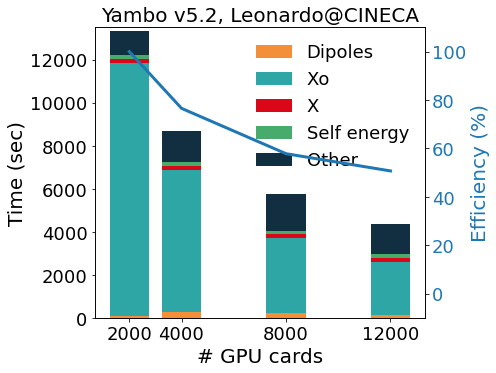

In [9]:
build_scaling_plot(scaling=scaling, x_axis='mpi', x_label='# GPU cards',
                   pile=pile, colors=colors, bar_width=1500, efficiency=True,
                   legend_loc='upper right', title=r'Yambo v5.2, Leonardo@CINECA', 
                   file_name='yambo_scaling_gpu.png', y_lim=[0,13500])

In [10]:
def build_speedup_plot(scaling, label='yambo', title=None, y_lim=None, x_axis='mpi', file_name='speedup.png'):
    mylinestyle = {'marker':'o', 
                   'linewidth':3, 
                   'markersize':10, 
                   'markeredgewidth':3, 
                   'markerfacecolor':'white'}
    fig, ax = plt.subplots(figsize=(10, 7))
    if x_axis=='mpi':
        xlabel = 'MPI tasks'
    elif x_axis=='nodes':
        xlabel = 'Nodes'
    else:
        xlabel = x_axis
    ax.set_xlabel(xlabel,fontsize=20)
    ax.set_ylabel('Speedup',fontsize=20)
    ax.plot(scaling[x_axis], scaling['ideal'], color='gray', label='ideal', linestyle='dashed')
    ax.plot(scaling[x_axis], scaling['speedup'], 
             color='#2EA6A6', marker='.', markersize=15,
             label=label)
    if y_lim: ax.set_ylim(y_lim)
    ax.legend()
    ax.legend(fontsize='18',framealpha=0.0)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
    plt.xticks(scaling[x_axis])
    if title: plt.title(title, fontsize=20)
    plt.savefig(file_name, bbox_inches='tight')

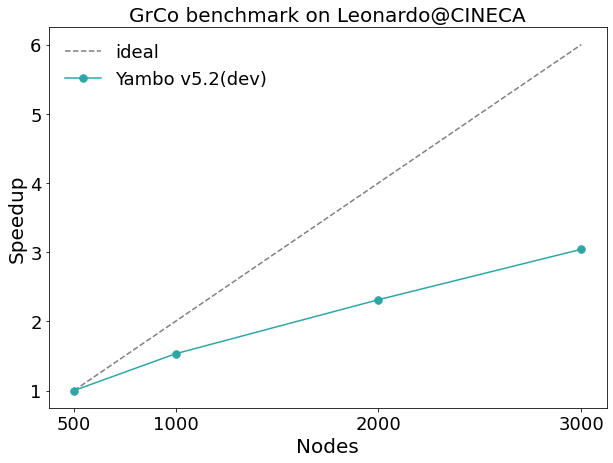

In [11]:
build_speedup_plot(scaling=scaling, title=r'GrCo benchmark on Leonardo@CINECA', label=r'Yambo v5.2(dev)', x_axis='nodes')